In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
data = pd.read_csv('AB_NYC_2019.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

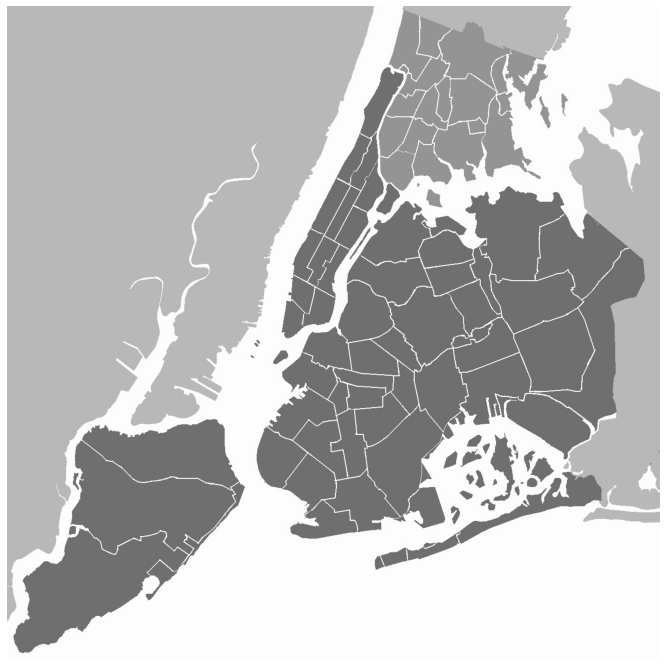

In [5]:
img = Image.open('New_York_City_.png')

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(img, extent=(0, 1, 0, 1))
plt.show()

In [6]:
coords = data.loc[:, ['longitude', 'latitude']].copy()
coords

,longitude,latitude
0,-73.97237,40.64749
1,-73.98377,40.75362
2,-73.94190,40.80902
3,-73.95976,40.68514
4,-73.94399,40.79851
...,...,...
48890,-73.94995,40.67853
48891,-73.93317,40.70184
48892,-73.94867,40.81475
48893,-73.99112,40.75751


In [7]:
min_max_scaler = MinMaxScaler()

coords = pd.DataFrame(min_max_scaler.fit_transform(coords), columns=coords.columns)
coords

,longitude,latitude
0,0.511921,0.357393
1,0.490469,0.614199
2,0.569257,0.748252
3,0.535649,0.448496
4,0.565324,0.722820
...,...,...
48890,0.554109,0.432502
48891,0.585684,0.488906
48892,0.556517,0.762117
48893,0.476639,0.623612


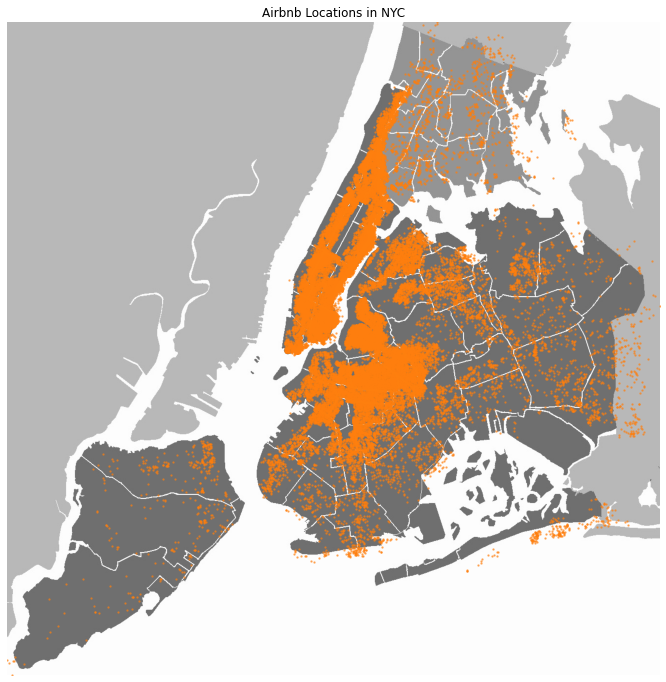

In [8]:
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(img, extent=(0, 1, 0, 1))
plt.scatter(x=coords['longitude'], y=coords['latitude'], s=2, c='#ff7f0e', alpha=0.5)
plt.title("Airbnb Locations in NYC")
plt.show()

In [9]:
unneeded_columns = ['id', 'name', 'host_id', 'host_name']

data = data.drop(unneeded_columns, axis=1)

In [10]:
data.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [11]:
print("Total missing values:", data.isna().sum().sum())

Total missing values: 20104


In [12]:
data.isna().mean()

neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
last_review                       0.205583
reviews_per_month                 0.205583
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

In [13]:
data = data.drop('last_review', axis=1)

data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [14]:
data['availability_365'] = data['availability_365'].apply(lambda x: 1 if x > 165 else 0)

In [15]:
data['availability_365'].value_counts() / len(data['availability_365'])

0    0.676756
1    0.323244
Name: availability_365, dtype: float64

In [16]:
{feature: list(data[feature].unique()) for feature in data.columns if data.dtypes[feature] == 'object'}

{'neighbourhood_group': ['Brooklyn',
  'Manhattan',
  'Queens',
  'Staten Island',
  'Bronx'],
 'neighbourhood': ['Kensington',
  'Midtown',
  'Harlem',
  'Clinton Hill',
  'East Harlem',
  'Murray Hill',
  'Bedford-Stuyvesant',
  "Hell's Kitchen",
  'Upper West Side',
  'Chinatown',
  'South Slope',
  'West Village',
  'Williamsburg',
  'Fort Greene',
  'Chelsea',
  'Crown Heights',
  'Park Slope',
  'Windsor Terrace',
  'Inwood',
  'East Village',
  'Greenpoint',
  'Bushwick',
  'Flatbush',
  'Lower East Side',
  'Prospect-Lefferts Gardens',
  'Long Island City',
  'Kips Bay',
  'SoHo',
  'Upper East Side',
  'Prospect Heights',
  'Washington Heights',
  'Woodside',
  'Brooklyn Heights',
  'Carroll Gardens',
  'Gowanus',
  'Flatlands',
  'Cobble Hill',
  'Flushing',
  'Boerum Hill',
  'Sunnyside',
  'DUMBO',
  'St. George',
  'Highbridge',
  'Financial District',
  'Ridgewood',
  'Morningside Heights',
  'Jamaica',
  'Middle Village',
  'NoHo',
  'Ditmars Steinway',
  'Flatiron Distr

In [17]:
def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [18]:
data = onehot_encode(
    data,
    columns=['neighbourhood_group', 'neighbourhood', 'room_type'],
    prefixes=['G', 'N', 'R']
)

In [19]:
indexNames = data[data['price'] == 0].index
data.drop(indexNames, inplace=True)

In [20]:
y = data['availability_365'].copy()
X = data.drop('availability_365', axis=1).copy()

In [21]:
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=200)

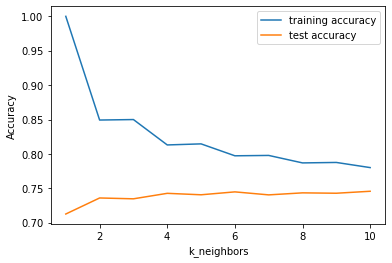

In [23]:

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)
for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("k_neighbors")
plt.legend()



In [24]:
data.to_csv("abnb_2.csv")

In [25]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=2, random_state=40)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.734
Accuracy on test set: 0.732


In [26]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["under165", "over165"], impurity=False, filled=True)

In [27]:
import graphviz

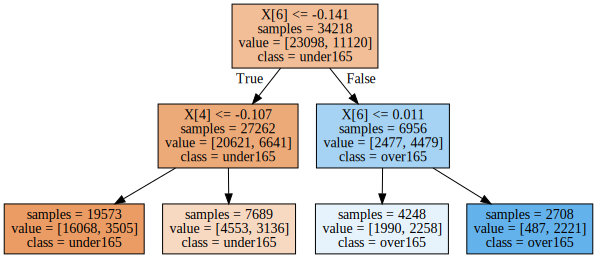

In [28]:
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [29]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.        0.        0.        0.        0.2197678 0.        0.7802322
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0

In [31]:
data.columns

Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'G_Bronx', 'G_Brooklyn',
       ...
       'N_Williamsburg', 'N_Willowbrook', 'N_Windsor Terrace', 'N_Woodhaven',
       'N_Woodlawn', 'N_Woodrow', 'N_Woodside', 'R_Entire home/apt',
       'R_Private room', 'R_Shared room'],
      dtype='object', length=237)

In [32]:
from sklearn.ensemble import RandomForestClassifier

#X, y = data(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                        random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))


Accuracy on training set: 1.000
Accuracy on test set: 0.784


In [33]:
import mglearn

In [37]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.692414696015056

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Test score: {:.2f}".format(logreg.score(X_test, y_test)))

Test score: 0.73


In [39]:
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train) 
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent))) 
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))


Unique predicted labels: [0]
Test score: 0.68


In [40]:
dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))


dummy score: 0.68


In [41]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logreg, X, y)
print("Cross-validation scores: {}".format(scores))

logreg = LogisticRegression(C=0.1).fit(X_train, y_train) 
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))


Cross-validation scores: [0.71750026 0.74767311 0.71238621 0.72108009 0.69864975]
logreg score: 0.73


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=1000, random_state=13)
cross_val_score(rf, X_train, y_train, scoring='recall')



array([0.512     , 0.51452632, 0.51284211, 0.51494737, 0.50736842])

In [43]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train) 
pred_tree = tree.predict(X_test)
print("Test score: {:.2f}".format(tree.score(X_test, y_test)))
print("Train score: {:.2f}".format(tree.score(X_train, y_train)))


Test score: 0.74
Train score: 0.73


In [44]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[7695  600]
 [2724 1202]]


In [45]:

print("Most frequent class:") 
print(confusion_matrix(y_test, pred_most_frequent)) 
print("\nDummy model:") 
print(confusion_matrix(y_test, pred_dummy))
print("\nDecision tree:") 
print(confusion_matrix(y_test, pred_tree)) 
print("\nLogistic Regression") 
print(confusion_matrix(y_test, pred_logreg))


Most frequent class:
[[8295    0]
 [3926    0]]

Dummy model:
[[8295    0]
 [3926    0]]

Decision tree:
[[7379  916]
 [2316 1610]]

Logistic Regression
[[7695  600]
 [2724 1202]]


In [46]:
from sklearn.metrics import f1_score
print("f1 score most frequent: {:.2f}".format( f1_score(y_test, pred_most_frequent)))
print("f1 score dummy: {:.2f}".format(f1_score(y_test, pred_dummy))) 
print("f1 score tree: {:.2f}".format(f1_score(y_test, pred_tree))) 
print("f1 score logistic regression: {:.2f}".format(
            f1_score(y_test, pred_logreg)))


f1 score most frequent: 0.00
f1 score dummy: 0.00
f1 score tree: 0.50
f1 score logistic regression: 0.42


In [47]:
from sklearn.metrics import classification_report 
print(classification_report(y_test, pred_most_frequent,
                                target_names=["over 200", "under"]))

              precision    recall  f1-score   support

    over 200       0.68      1.00      0.81      8295
       under       0.00      0.00      0.00      3926

    accuracy                           0.68     12221
   macro avg       0.34      0.50      0.40     12221
weighted avg       0.46      0.68      0.55     12221



/Users/jihyangseo/Desktop/GitGoods/miniconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jihyangseo/Desktop/GitGoods/miniconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jihyangseo/Desktop/GitGoods/miniconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

In [52]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print("AUC for Random Forest: {:.3f}".format(rf_auc))

AUC for Random Forest: 0.825


In [49]:

from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))


Accuracy: 0.728
Confusion matrix:
[[7694  601]
 [2722 1204]]


In [51]:
from sklearn.metrics import roc_auc_score
lr_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
print("AUC for Linear Regression: {:.3f}".format(lr_auc))

AUC for Linear Regression: 0.755
